In [19]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import json
from datetime import datetime
from statsmodels.api import qqplot
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
data_path = '../data' 
excel_files = sorted(glob.glob(os.path.join(data_path, 'Totalizadores*.xlsx')))

if not excel_files:
    print(f"No se encontraron archivos .xlsx en la carpeta: {data_path}")
else:
    print(f"Se encontraron {len(excel_files)} Archivos Excel encontrados y ordenados.")
    print([os.path.basename(f) for f in excel_files])

sheets_dict = {}

for file in excel_files:
    print(f"\nProcesando: {os.path.basename(file)}")
    xls = pd.ExcelFile(file)
    for sheet in xls.sheet_names:
        try:
            df = pd.read_excel(file, sheet_name=sheet, engine='openpyxl')
            if 'HORA' not in df.columns or 'DIA' not in df.columns:
                continue
                
            df['HORA'] = df['HORA'].astype(str).str.strip()
            df = df[df['HORA'].str.contains('23:59', na=False)]
            if df.empty:
                continue
                
            df['Date'] = pd.to_datetime(df['DIA']).dt.date
            df = df.drop(columns=['HORA', 'DIA'], errors='ignore')
            df = df.set_index('Date')
            
            # Prefijo para evitar colisión
            df = df.add_prefix(f"{sheet}_")
            
            # Agregar al diccionario
            if sheet not in sheets_dict:
                sheets_dict[sheet] = []
            sheets_dict[sheet].append(df)
            
            print(f"  {sheet}: {len(df)} días")
            
        except Exception as e:
            print(f"  Error en {sheet}: {e}")
            continue

# Unificar POR HOJA (evita duplicados)
unified_by_sheet = {}
for sheet, dfs_list in sheets_dict.items():
    if dfs_list:
        unified = pd.concat(dfs_list, axis=0)
        unified = unified[~unified.index.duplicated(keep='last')]  
        unified_by_sheet[sheet] = unified

# Unir todas las hojas por fecha
df_raw = None
for sheet, df in unified_by_sheet.items():
    prefixed_cols = [col for col in df.columns]
    df = df[prefixed_cols]
    if df_raw is None:
        df_raw = df
    else:
        df_raw = df_raw.join(df, how='outer')  

df_raw = df_raw.sort_index()

print(f"\nDataset unificado: {df_raw.shape[0]} días × {df_raw.shape[1]} columnas")
print(f"Rango: {df_raw.index.min()} - {df_raw.index.max()}")

Se encontraron 3 Archivos Excel encontrados y ordenados.
['Totalizadores Planta - 2021_2023.xlsx', 'Totalizadores Planta 2020_2022.xlsx', 'Totalizadores Planta 2022_2023.xlsx']

Procesando: Totalizadores Planta - 2021_2023.xlsx
  Consolidado KPI: 611 días
  Consolidado Produccion: 611 días
  Totalizadores Produccion: 611 días
  Consolidado EE: 611 días
  Totalizadores Energia: 611 días
  Consolidado Agua: 611 días
  Totalizadores Agua: 611 días
  Consolidado GasVapor: 611 días
  Totalizadores Gas y Vapor: 611 días
  Consolidado Aire: 611 días
  Totalizadores Aire: 611 días
  Totalizadores CO2: 612 días
  Totalizadores Efluentes: 611 días
  Totalizadores Glicol: 611 días
  Seguimiento Dia: 611 días
  Auxiliar: 611 días

Procesando: Totalizadores Planta 2020_2022.xlsx
  Consolidado KPI: 622 días
  Consolidado Produccion: 622 días
  Totalizadores Produccion: 622 días
  Consolidado EE: 622 días
  Totalizadores Energia: 622 días
  Consolidado Agua: 622 días
  Totalizadores Agua: 622 días
  

#### 1.1.3 CHECKSUM

In [69]:
# 1.1.3: CHECKSUM 
def compute_md5(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

checksum = compute_md5(df_raw)
checksum_data = {
    "timestamp": datetime.now().isoformat(),
    "file": "df_raw_unified",
    "rows": len(df_raw),
    "columns": len(df_raw.columns),
    "md5": checksum
}

os.makedirs('../data', exist_ok=True)
with open('../data/checksums.json', 'w') as f:
    json.dump([checksum_data], f, indent=4)

print(f"Checksum guardado: {checksum}")

Checksum guardado: 21c87bc1dc65bed5c3527e751117b9a0


#### 1.1.4 Descripción del Dataset

In [64]:
print("DESCRIPCIÓN DEL DATASET")
print(f"Filas: {df_raw.shape[0]} | Columnas: {df_raw.shape[1]}")
print(f"Rango fechas: {df_raw.index.min()} - {df_raw.index.max()}")

# Tipos
print("\nTipos de variables:")
print(df_raw.dtypes.value_counts())

# Rangos
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
ranges = df_raw[numeric_cols].agg(['min', 'max', 'mean', 'std']).T
ranges = ranges.round(2)
print("\nRangos numéricos (muestra):")
print(ranges.head(10))

DESCRIPCIÓN DEL DATASET
Filas: 1185 | Columnas: 452
Rango fechas: 2020-07-01 - 2023-10-25

Tipos de variables:
float64    404
int64       39
object       9
Name: count, dtype: int64

Rangos numéricos (muestra):
                                      min           max          mean  \
Consolidado KPI_EE Planta / Hl       0.00  1.849170e+03  1.055000e+01   
Consolidado KPI_EE Elaboracion / Hl  0.00  1.346800e+02  1.080000e+00   
Consolidado KPI_EE Bodega / Hl      -0.41  1.569600e+02  1.020000e+00   
Consolidado KPI_EE Cocina / Hl       0.00  1.544000e+01  3.600000e-01   
Consolidado KPI_EE Envasado / Hl     0.00  3.915542e+12  6.334438e+09   
Consolidado KPI_EE Linea 2 / Hl     -0.09  9.565000e+01  5.640000e+00   
Consolidado KPI_EE Linea 3 / Hl      0.00  9.750000e+01  1.970000e+00   
Consolidado KPI_EE Linea 4 / Hl      0.00  1.297300e+02  1.950000e+00   
Consolidado KPI_EE Linea 5 / Hl       NaN           NaN           NaN   
Consolidado KPI_EE Servicios / Hl    0.00  1.341500e+03  6.

#### 1.1.5: Identificación y cuantificación de valores faltantes

VALORES FALTANTES
Columnas con missing: 220
                                 Missing      %
Consolidado KPI_EE Linea 5 / Hl     1185  100.0
Consolidado KPI_Unnamed: 21         1185  100.0
Consolidado KPI_Unnamed: 22         1185  100.0
Consolidado KPI_Unnamed: 35         1185  100.0
Consolidado KPI_Unnamed: 84         1185  100.0
Consolidado KPI_Unnamed: 65         1185  100.0
Consolidado KPI_Unnamed: 67         1185  100.0
Consolidado KPI_Unnamed: 72         1185  100.0
Consolidado KPI_Unnamed: 46         1185  100.0
Consolidado KPI_Unnamed: 66         1185  100.0


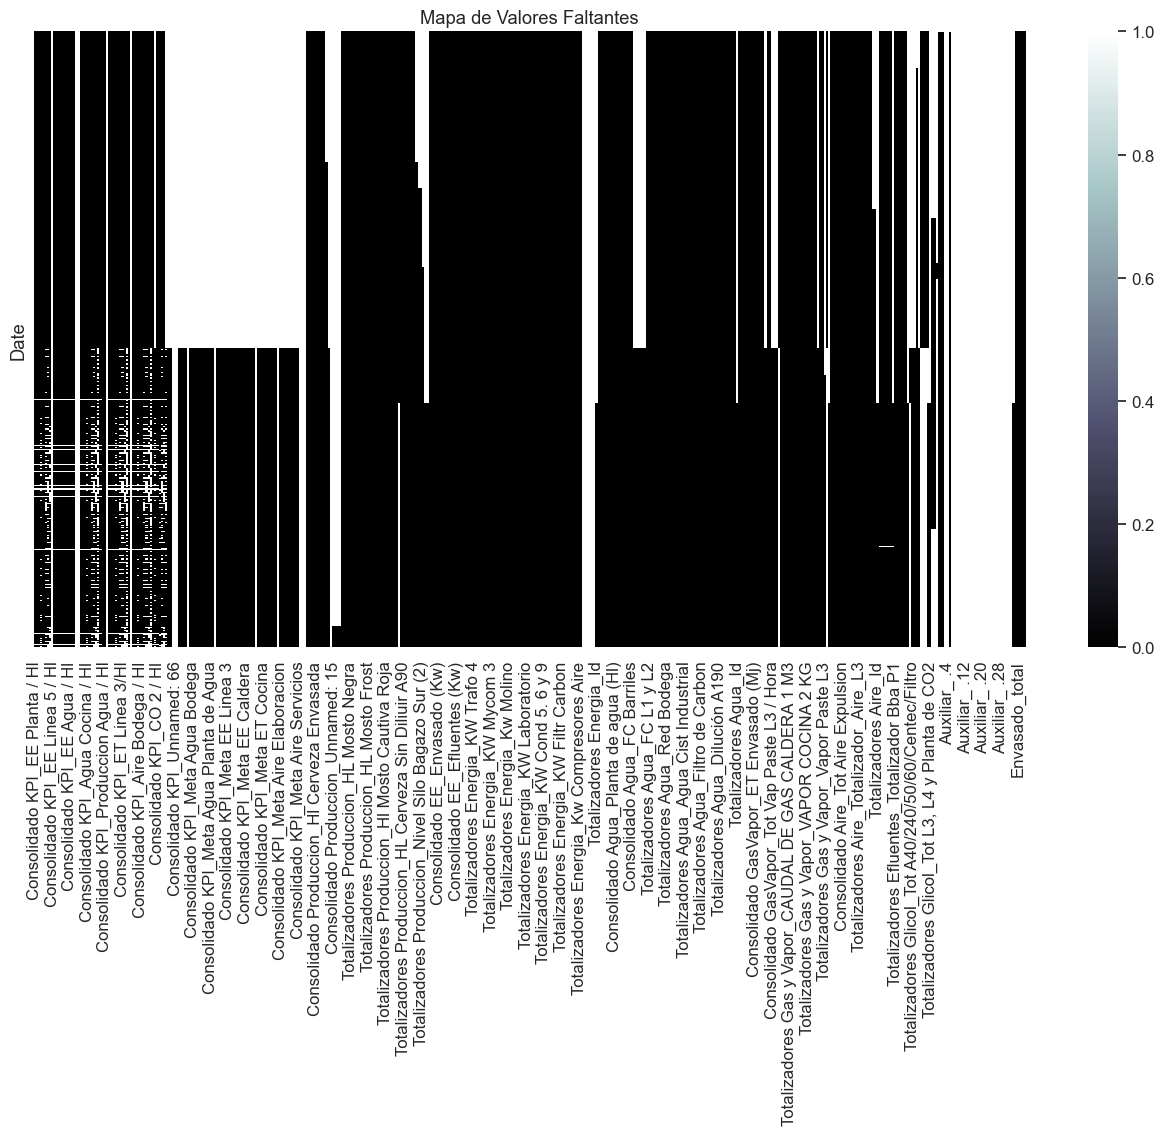

In [39]:
print("VALORES FALTANTES")

missing = df_raw.isna().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({'Missing': missing, '%': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('%', ascending=False)

print(f"Columnas con missing: {len(missing_df)}")
print(missing_df.head(10))

# Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df_raw.isna(), cbar=True, yticklabels=False, cmap='bone')
plt.title('Mapa de Valores Faltantes')
plt.show()

#### 1.1.6: Detección de valores atípicos y errores

In [ ]:
print("ERRORES Y OUTLIERS")

# Errores de Excel
error_patterns = ['#VALUE!', '#DIV/0!', '#N/A', '#REF!']
error_mask = df_raw.astype(str).apply(lambda x: x.str.contains('|'.join(error_patterns), na=False))
errors = error_mask.sum().sum()
print(f"Errores de Excel detectados: {errors}")

# Outliers (IQR)
Q1 = df_raw[numeric_cols].quantile(0.25)
Q3 = df_raw[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = ((df_raw[numeric_cols] < (Q1 - 1.5 * IQR)) | (df_raw[numeric_cols] > (Q3 + 1.5 * IQR)))
outliers_per_col = outlier_mask.sum()
print(f"Outliers por columna (top 5):")
print(outliers_per_col.sort_values(ascending=False).head())


ERRORES Y OUTLIERS
Errores de Excel detectados: 0
Outliers por columna (top 5):
Totalizadores CO2_Totalizador_L2_Barriles               282
Totalizadores Agua_Rinser                               279
Totalizadores Agua_Red Bodega                           252
Totalizadores Gas y Vapor_CAUDAL DE GAS CALDERA 1 M3    252
Totalizadores Produccion_HL Mosto Heineken              244
dtype: int64


## 1.2. Análisis Temporal

#### 1.2.1: Evolución del consumo Frío(Kw) - con Outliers

Target detectado: Consolidado EE_Frio (Kw)


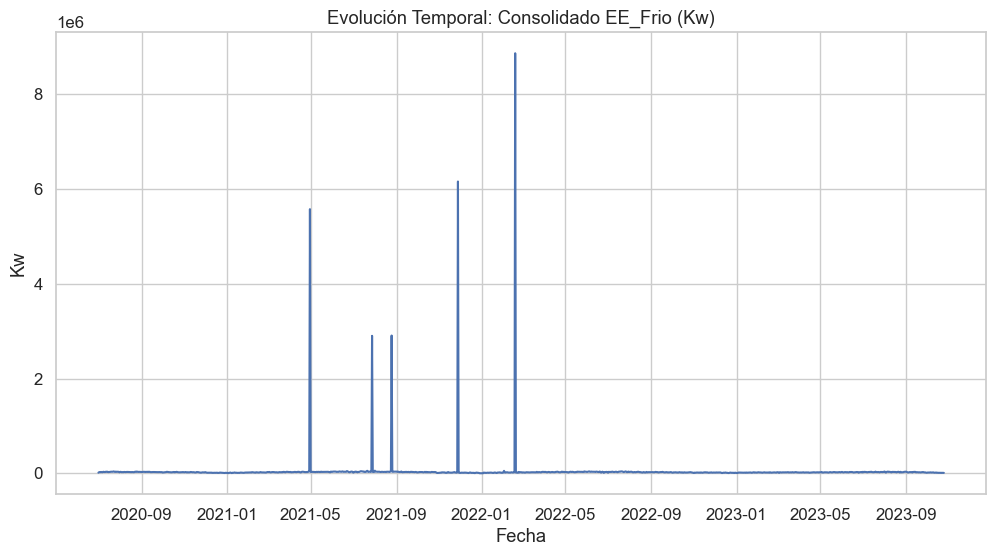

In [67]:
target_col = [col for col in df_raw.columns if 'Frio' in col and '(Kw)' in col][0]
print(f"Target detectado: {target_col}")

plt.figure()
df_raw[target_col].plot()
plt.title(f'Evolución Temporal: {target_col}')
plt.ylabel('Kw')
plt.xlabel('Fecha')
plt.show()

#### 1.2.2: Estacionalidad (Mensual y Semanal) - Con outliers

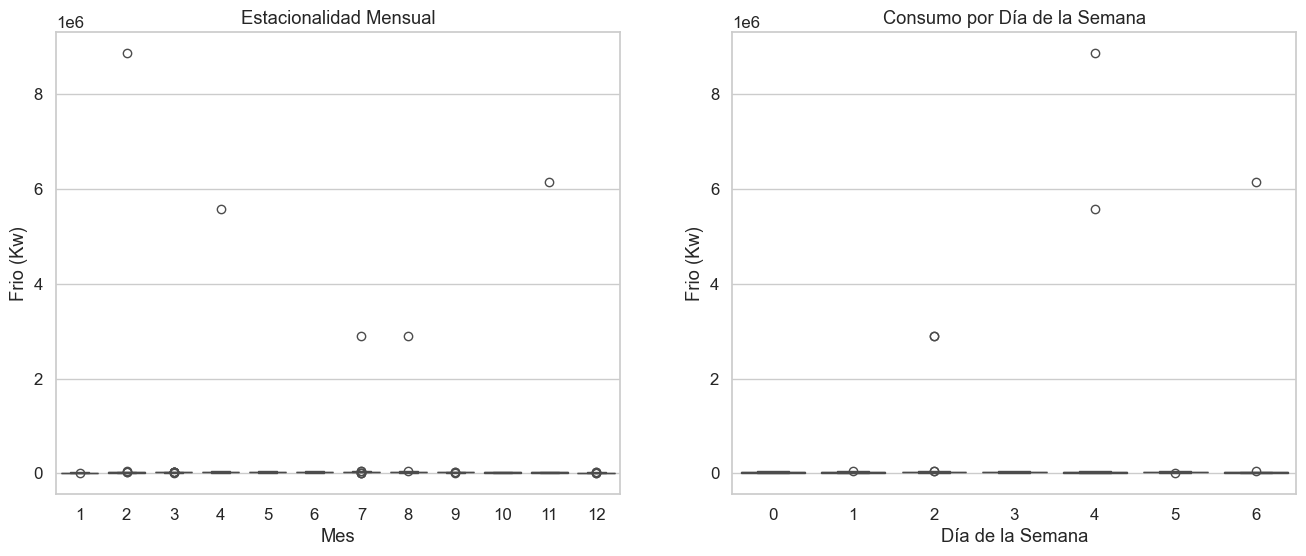

Correlación día de la semana vs Consolidado EE_Frio (Kw): 0.030


In [43]:
df_plot = df_raw.copy()
df_plot['month'] = pd.to_datetime(df_plot.index).month
df_plot['weekday'] = pd.to_datetime(df_plot.index).dayofweek

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='month', y=target_col, data=df_plot, ax=ax1)
ax1.set_title('Estacionalidad Mensual')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Frio (Kw)')

sns.boxplot(x='weekday', y=target_col, data=df_plot, ax=ax2)
ax2.set_title('Consumo por Día de la Semana')
ax2.set_xlabel('Día de la Semana')
ax2.set_ylabel('Frio (Kw)')
plt.show()

print(f"Correlación día de la semana vs {target_col}: {df_plot[target_col].corr(df_plot['weekday']):.3f}")

### 1.3. Análisis de Correlaciones

#### 1.3.1: Matriz de Correlaciones entre variables numéricas

MATRIZ DE CORRELACIÓN
Columnas numéricas para correlación: 452


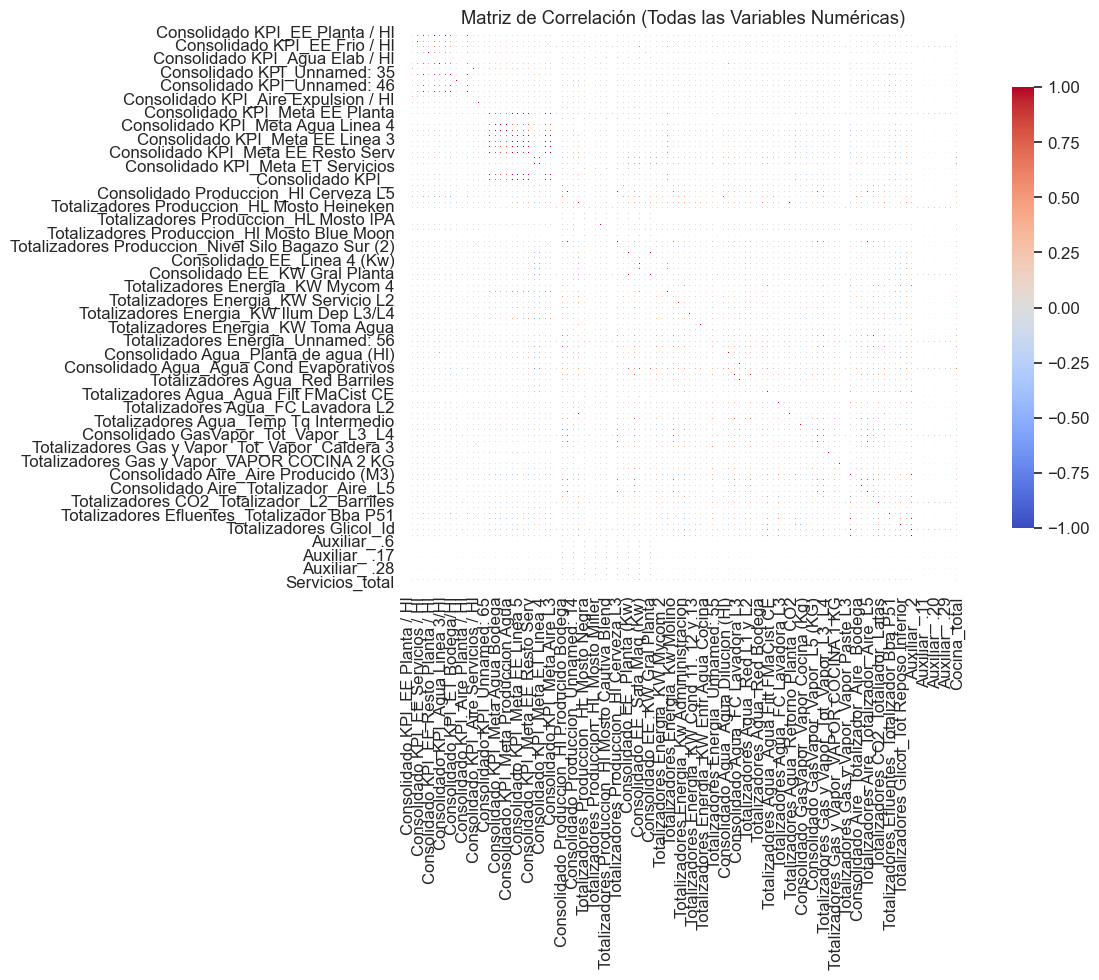

In [45]:
print("MATRIZ DE CORRELACIÓN")

# convertir comas decimales a puntos
def clean_numeric_column(col):
    if col.dtype == 'object':
        # Reemplazar comas por puntos, eliminar puntos de miles
        col = col.astype(str).str.replace(r'\.', '', regex=True)  
        col = col.str.replace(',', '.', regex=False)              
        col = pd.to_numeric(col, errors='coerce') # Convertir a numérico, NaN si falla
    return col


df_numeric = df_raw.copy()
for col in df_numeric.columns:
    df_numeric[col] = clean_numeric_column(df_numeric[col])

# seleccionar solo columnas numéricas
numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
df_corr = df_numeric[numeric_cols]

print(f"Columnas numéricas para correlación: {len(df_corr.columns)}")

# calcular correlación
corr_matrix = df_corr.corr()

# visualizar
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación (Todas las Variables Numéricas)')
plt.tight_layout()
plt.show()

#### 1.3.2 Top 15 variables más correlacionadas con Frío (Kw)

Top 15 variables más correlacionadas con Frio (kW):
Consolidado EE_Resto Serv (Kw)             0.996528
Consolidado KPI_EE Resto Serv / Hl         0.961311
Consolidado EE_Sala Maq (Kw)               0.917501
Consolidado Agua_Agua Cond Evaporativos    0.831768
Consolidado KPI_EE Frio / Hl               0.807407
Consolidado KPI_EE Sala Maq / Hl           0.733277
Totalizadores Energia_KW Mycom 7           0.691888
Totalizadores Agua_Rechazo Osmosis         0.687985
Totalizadores Energia_KW Atlas 3           0.679980
Totalizadores Energia_KW Mycom 1           0.646499
Consolidado KPI_Meta ET Linea 5            0.600733
Consolidado KPI_Meta ET Elab               0.600733
Consolidado KPI_Meta ET Linea 4            0.600733
Consolidado KPI_Meta ET Bodega             0.600733
Consolidado KPI_Meta ET Planta             0.600733
Name: Consolidado EE_Frio (Kw), dtype: float64


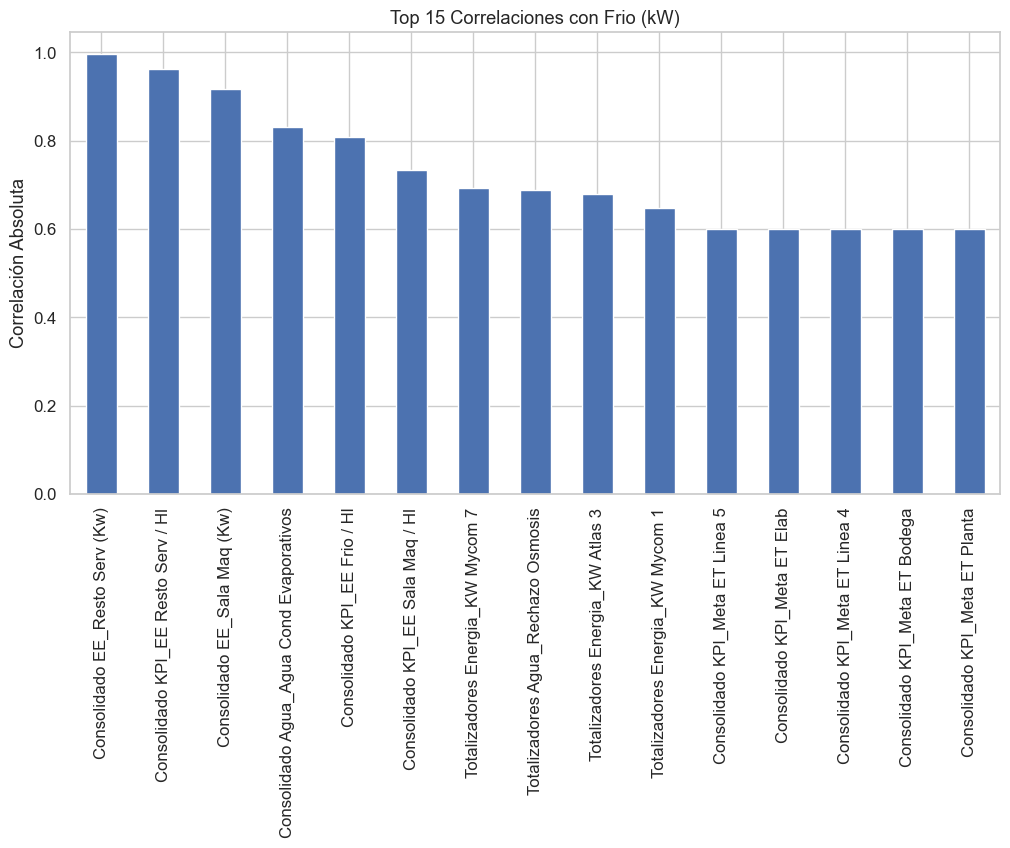

In [68]:
top_corr = corr_matrix[target_col].abs().sort_values(ascending=False).head(16)
top_corr = top_corr.drop(target_col, errors=0)
print("Top 15 variables más correlacionadas con Frio (kW):")
print(top_corr)

plt.figure()
top_corr.plot(kind='bar')
plt.title('Top 15 Correlaciones con Frio (kW)')
plt.ylabel('Correlación Absoluta')
plt.show()

#### 1.3.3. Análisis de Multiconealidad entre predictores

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
print("ANÁLISIS DE MULTICOLINEALIDAD")

numeric_df = df_raw.select_dtypes(include=[np.number]).dropna(axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

high_vif = vif_data[vif_data['VIF'] > 10]
print(f"Features con VIF > 10 (multicolinealidad): {len(high_vif)}")
print(high_vif.head())

ANÁLISIS DE MULTICOLINEALIDAD
Features con VIF > 10 (multicolinealidad): 182
                                      feature           VIF
0      Consolidado KPI_Agua Planta de Agua/Hl  1.748987e+02
1        Consolidado KPI_Produccion Agua / Hl  1.458354e+02
2          Consolidado Produccion_Hl de Mosto  7.545307e+05
3    Consolidado Produccion_Hl Cerveza Cocina  7.304366e+06
4  Consolidado Produccion_Hl Producido Bodega  8.870019e+06


### 1.4: Visualizaciones Requeridas

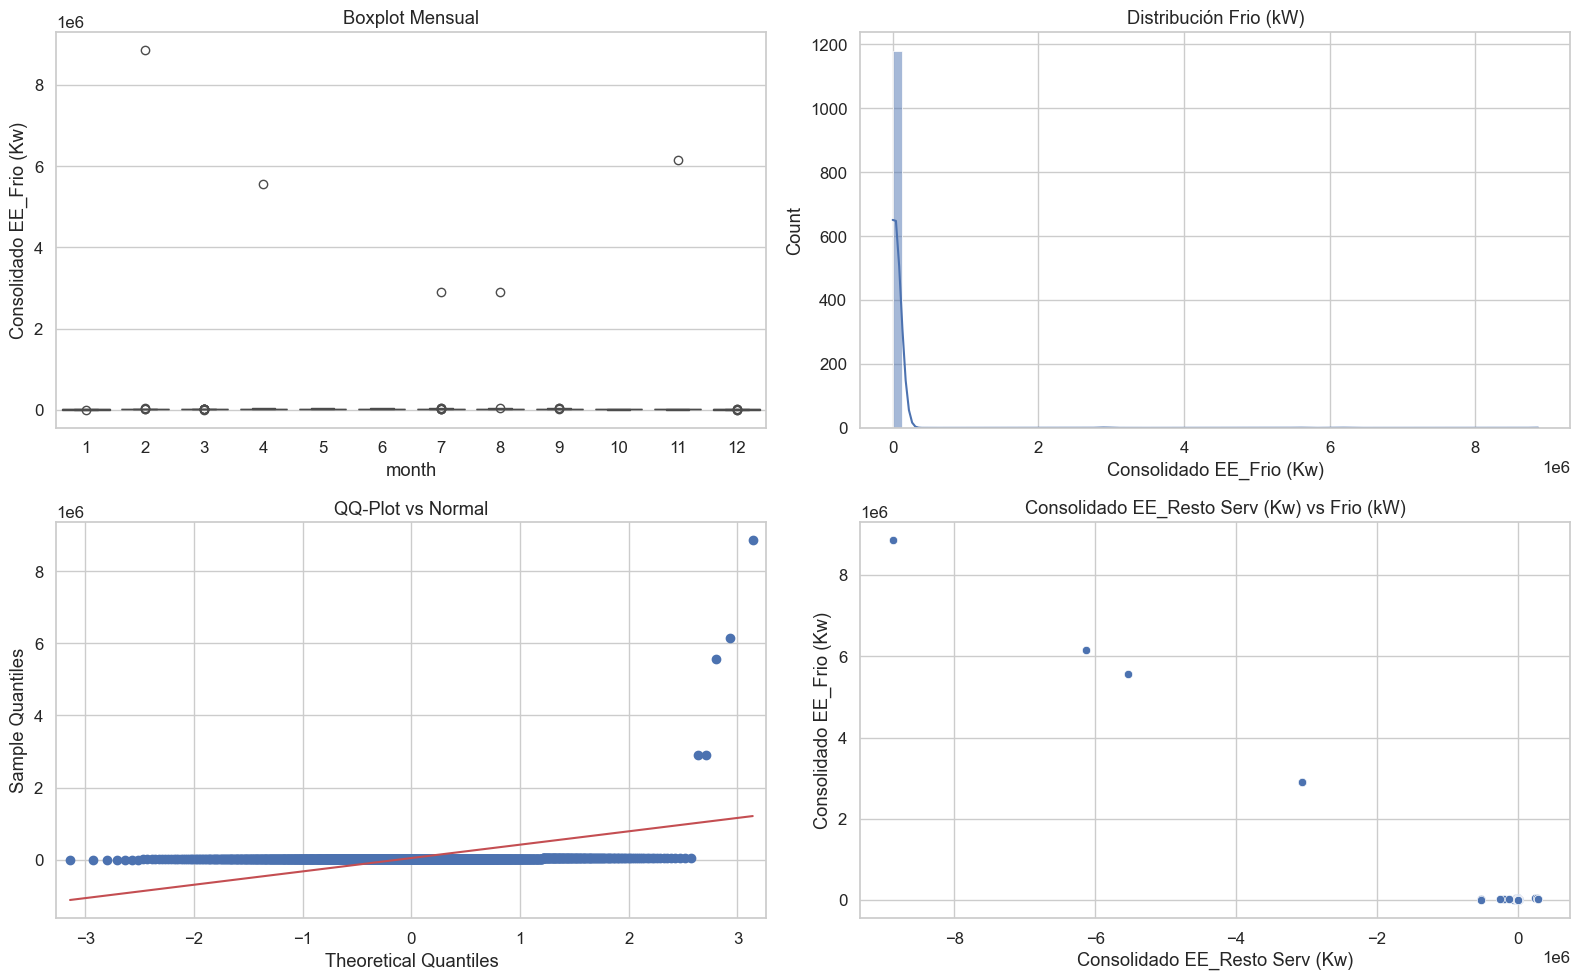

In [50]:
### 1.4: Visualizaciones Requeridas (con outliers y errores incluidos)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Boxplot mensual
sns.boxplot(x='month', y=target_col, data=df_plot, ax=axes[0,0])
axes[0,0].set_title('Boxplot Mensual')

# Histograma
sns.histplot(df_raw[target_col].dropna(), kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribución Frio (kW)')

# QQ Plot
qqplot(df_raw[target_col].dropna(), line='s', ax=axes[1,0])
axes[1,0].set_title('QQ-Plot vs Normal')

# Scatter top 1
top1 = top_corr.index[0]
sns.scatterplot(x=df_raw[top1], y=df_raw[target_col], ax=axes[1,1])
axes[1,1].set_title(f'{top1} vs Frio (kW)')

plt.tight_layout()
plt.show()

#### 1.4.2: Consumo por Área (Con outliers)

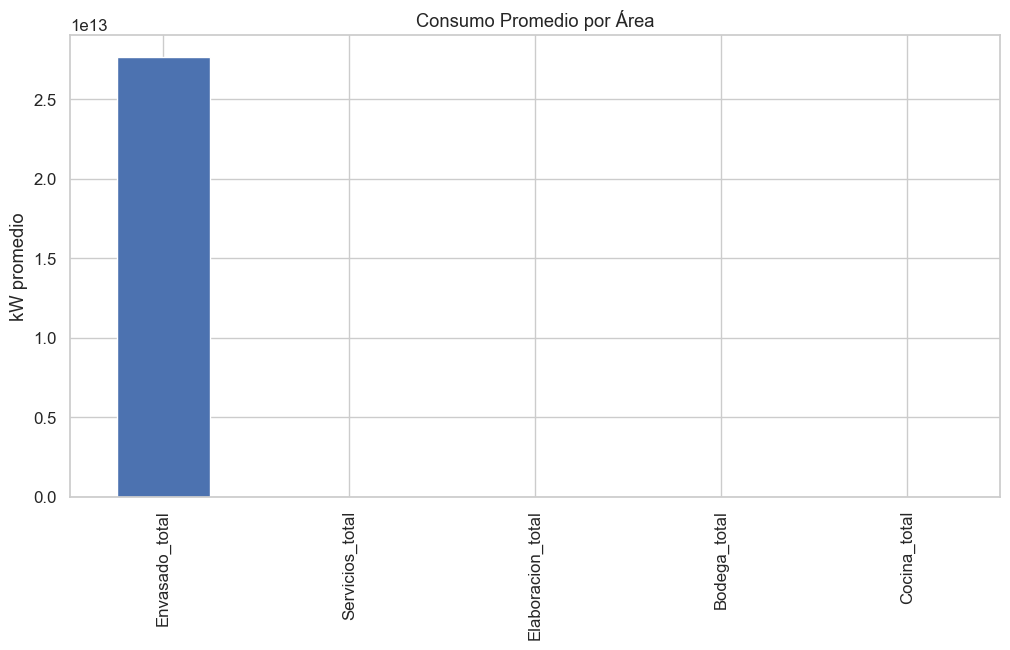

In [53]:
areas = ['Elaboracion', 'Envasado', 'Bodega', 'Cocina', 'Servicios']
area_cols = []
for area in areas:
    cols = [col for col in df_raw.columns if area in col and '(Kw)' in col]
    if cols:
        df_raw[f'{area}_total'] = df_raw[cols].sum(axis=1)
        area_cols.append(f'{area}_total')

if area_cols:
    area_df = df_raw[area_cols].mean().sort_values(ascending=False)
    area_df.plot(kind='bar')
    plt.title('Consumo Promedio por Área')
    plt.ylabel('kW promedio')
    plt.show()

In [70]:
# guardar dataset limpio
df_clean = df_raw.copy()
df_clean = df_clean.loc[:, (df_clean != 0).any(axis=0)]  # eliminar columnas cero
df_clean = df_clean.dropna(thresh=len(df_clean)*0.5, axis=1)  # eliminar >50% missing

df_clean.to_csv('../data/df_raw.csv')
print(f"Dataset limpio guardado: {df_clean.shape}")

Dataset limpio guardado: (1185, 295)


#### Extension de visualizaciones sin outliers

In [34]:
sane_threshold = 40000

df_viz = df_raw[df_raw[target_col] < sane_threshold].copy()

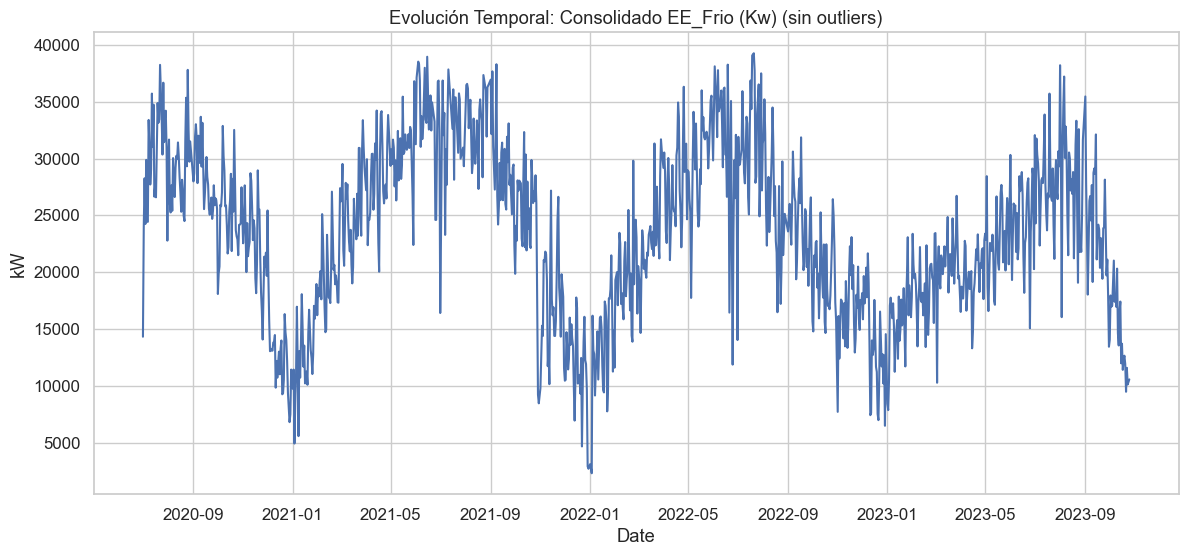

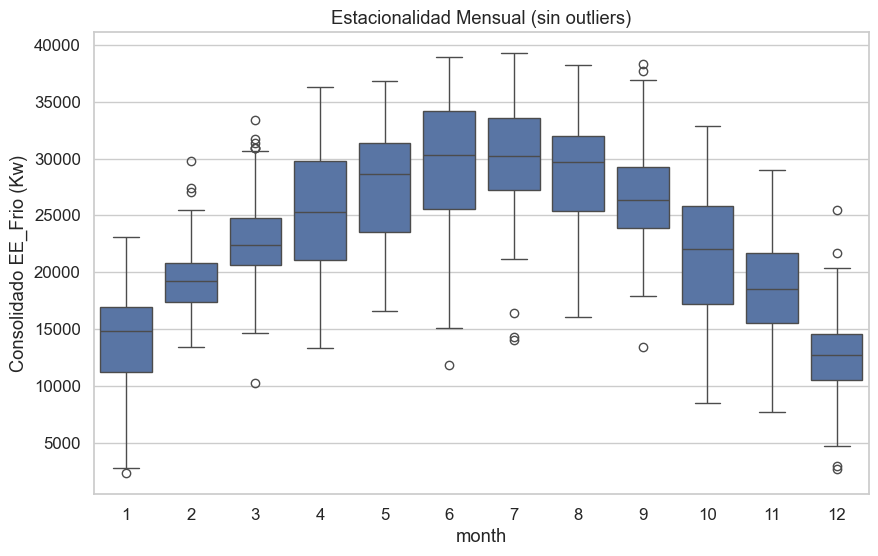

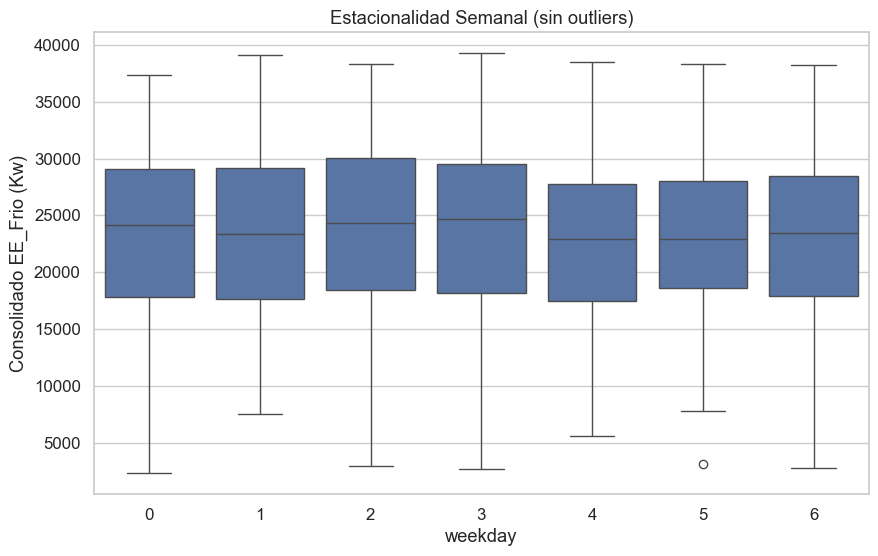

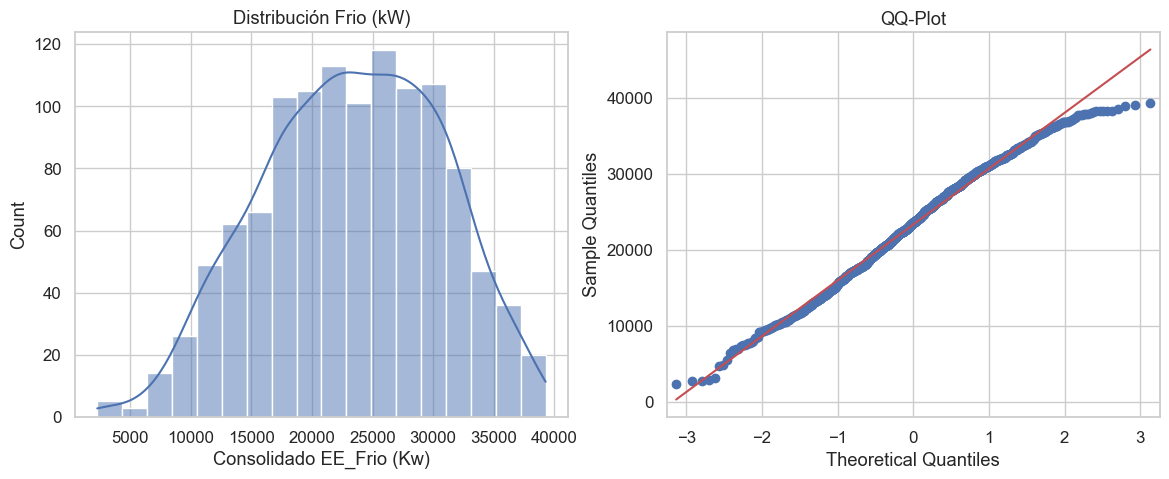

In [54]:
# 1. Serie temporal (limpia)
plt.figure(figsize=(14, 6))
df_viz[target_col].plot()
plt.title(f'Evolución Temporal: {target_col} (sin outliers)')
plt.ylabel('kW')
plt.show()

# 2. Boxplot mensual
df_viz['month'] = pd.to_datetime(df_viz.index).month
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y=target_col, data=df_viz)
plt.title('Estacionalidad Mensual (sin outliers)')
plt.show()

# 3. Boxplot semanal
df_viz['weekday'] = pd.to_datetime(df_viz.index).dayofweek
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y=target_col, data=df_viz)
plt.title('Estacionalidad Semanal (sin outliers)')
plt.show()

# 4. Histograma + QQ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_viz[target_col], kde=True, ax=ax1)
ax1.set_title('Distribución Frio (kW)')
qqplot(df_viz[target_col], line='s', ax=ax2)
ax2.set_title('QQ-Plot')
plt.show()

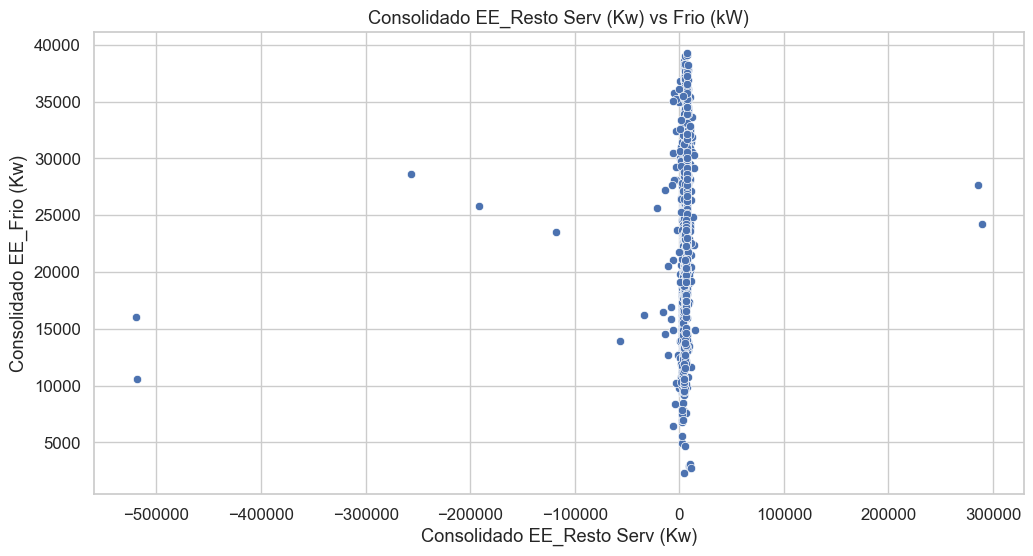

In [59]:
# Scatter top correlación
top1 = top_corr.index[0]
sns.scatterplot(x=df_viz[top1], y=df_viz[target_col])
plt.title(f'{top1} vs Frio (kW)')
plt.show()

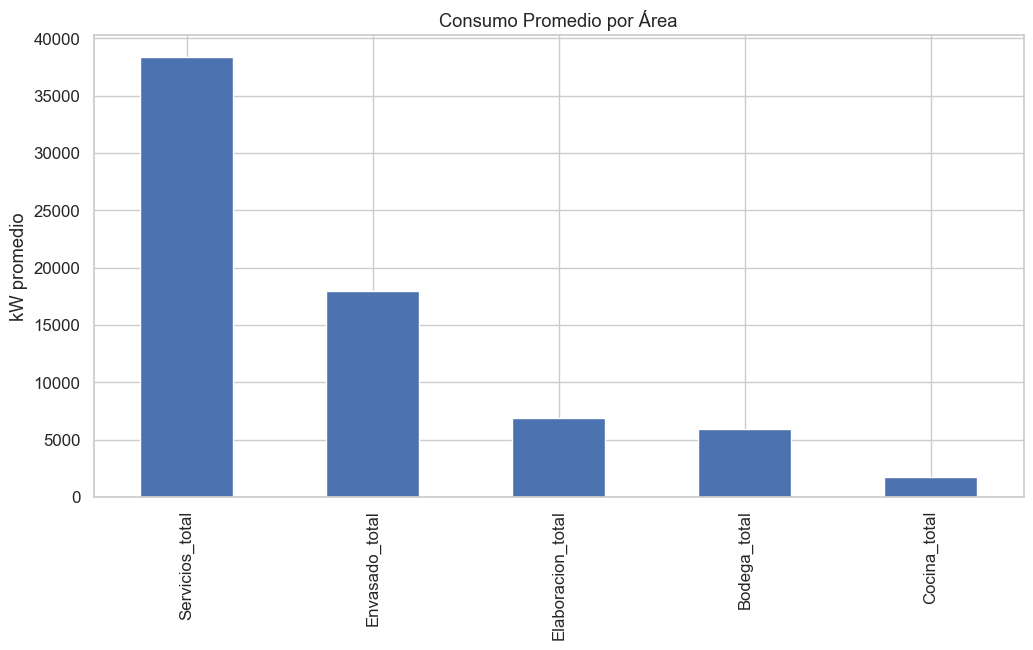

In [62]:
# Consumo por Área (Sin outliers)
areas = ['Elaboracion', 'Envasado', 'Bodega', 'Cocina', 'Servicios']
area_cols = []
for area in areas:
    cols = [col for col in df_raw.columns if area in col and '(Kw)' in col]
    if cols:
        df_viz[f'{area}_total'] = df_raw[cols].sum(axis=1)
        area_cols.append(f'{area}_total')

if area_cols:
    area_df = df_viz[area_cols].mean().sort_values(ascending=False)
    area_df.plot(kind='bar')
    plt.title('Consumo Promedio por Área')
    plt.ylabel('kW promedio')
    plt.show()